# CIFAR 10

Wayne Nixalo

2018/2/20-21

A redo of the [Fast.ai DL1L7 cifar10 notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson7-cifar10.ipynb) for some PyTorch practice.

Data: 

```
wget http://pjreddie.com/media/files/cifar.tgz
```
---

## 0. Setup

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.conv_learner import *
PATH = 'data/cifar10/'
os.makedirs(PATH, exist_ok=True)

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

Something changed, or I forgot something, so I have to move the data into class folders.

In [68]:
## move dataset
for dataset in ['test/','train/']:
    # get list of all classes
    g = glob(PATH + dataset + '*.png')
    g = [elem.split('_')[1].split('.png')[0] for elem in g]
    g = np.unique(g)

    # make class folders NOTE: I could've just uses `classes` from above
    for cls in g:
        os.mkdir(PATH + dataset + cls)
    # for cls in g:    # to reset
    #     os.rmdir(PATH + dataset + cls)

    # move dataset to class folders
    g = glob(PATH + dataset + '*.png')
    for fpath in g:
        cls = fpath.split('_')[-1].split('.png')[0]+'/'
        fname = fpath.split(dataset)[-1]
        os.rename(fpath, PATH+dataset+cls+fname)

In [46]:
# testing function mapping
f = lambda x: x + 2
a = [i for i in range(5)]
a = list(map(f, a))
a

[2, 3, 4, 5, 6]

In [60]:
def get_data(sz, bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [61]:
bs=256

## 1. View Data

In [62]:
data = get_data(32,4)

x,y = next(iter(data.trn_dl))

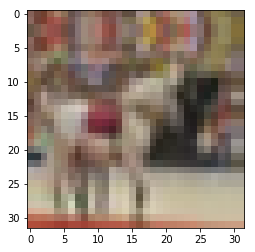

In [63]:
plt.imshow(data.trn_ds.denorm(x)[0])

I am so happy that worked. I swear Python analytics programming with Jupyter is super rewarding compared to other programming.

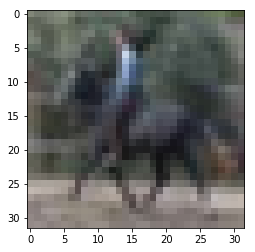

In [64]:
plt.imshow(data.trn_ds.denorm(x)[1])

checking I moved the validation set correctly

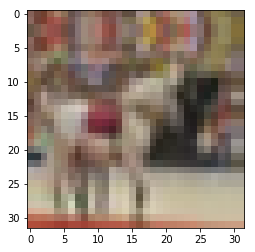

In [70]:
plt.imshow(data.val_ds.denorm(x)[0])

## 2. Fully Connected Model

In [71]:
data = get_data(32, bs)
lr = 1e-2

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) -1 )])
    def forward(self, x):
        x = x.view(x.size(0), -1) # input tensor shape
        for λ in self.layers:     # for each layer
            λ_x = λ(x)            # its output is itself acted upon the input
            x = F.relu(λ_x) # "nonlinearity" (activation function)
        return F.log_softmax(λ_x, dim=1) # output activation function

Understanding pytorch tensor reshaping

In [96]:
# make x a 1x1x32x32 Tensor
x = torch.autograd.Variable(torch.ones(1,1,32,32), requires_grad=True)
print(x.size())
# reshape x to a shape compatible with the size of its 1st dimension
# here: `-1` infers compatible size of dim2 given dim1=x.size(0)=1
# ==> returns a 1x1024 Tensor. (32**32=1024)
x = x.view(x.size(0), -1)
print(x.size())

torch.Size([1, 1, 32, 32])
torch.Size([1, 1024])


That means every layer of `SimpleNet` after the first is a $1 \times V$ vector, where $V$ is the 'Tensor volume' of the first layer (product of all dimensions).

What does that mean in English (I'm also explaining this to myself)?

It means that each layer is a straight up Linear, or, Fully-Connected layer. The classic neural-net image of columns of nodes.

Then why isn't the first layer also a $1 \times V$ vector?

That question is actually wrong: **all** the layers are linear. Notice it is **x** in `forward()` not the **layers** in `__init__()` that gets shaped. If you imagine `x` as a tensor traveling forward through the network: you see if first arrives as the image itself, which then goes through the first layer and is transformed via the `forward()` function from a $1\times{3}\times{32}\times{32}$ (I *think* that's the CIFAR10 size) tensor into a $1\times{V}$ tensor (vector), and continues forward in that shape through to the end of the network (where it becomes $1\times{C}$ (where $C$ is the number of classes), but I don't think that's been defined yet).

*Aha! `layers` aint a number! `layers` is an actual array (or smth) of PyTorch layers. So their in/out dims * ***are*** * included, $\Longrightarrow$ the output shape of $C=10$ * ***is*** * encoded.* Cool.

I've been confused in Deep Learning by conflating layers with their activations. Once you separate the actual layers of nodes from their tensors of activations, Neural Networks start to become much easier to imagine. For example, this is necessary to understand how come a Fully-Convolutional Network's architecture remains unchanged when input size is changed, despite the fact that the produced tensors vary *directly* with input size. The Conv filters remain stoically as they were.

*Goooot iit. Okay, so `SimpleNet` is initialized as an instance (or sub/child instance?) of the `torch.nn.Module` class, inheriting its intialization via `super().__init__()`. $\Longrightarrow$ it's base initialization is as the PyTorch base neural-network class, `torch.nn.Module`.*

***But!*** *more important than that: the `layers` attribute of the `SimpleNet` object is defined as a `torch.nn.ModuleList()` taking as its argument a list of `torch.nn.Linear(..)` which takes as * ***its*** * argument, the current and next index in the initializing `layers` argument, for $N-1$ indices in `layers`.*

An example that'll actually make sense:

`layers = [32*32*3, 40, 10]` $\Rightarrow$ `layers = [[3072, 40], [40, 10]]]`

`torch.nn.ModuleList([`

 `nn.Linear(layers[0], layers[1])`

`])`

Where layer 0 yields an input size of 3072 and output of 40, and layer 1: 40 and 10. The `layers` attribute of the `SimpleNet` object (our neural network), aka `SimpleNet.layers` thus consists of a `torch.nn.ModuleList` of two `torch.nn.Linear` neural-network layers, with the aforementioned in/out shapes.

Fuck yeah.

In [100]:
layers = [32*32*3, 40, 10]

print([[layers[i], layers[i+1] ]for i in range(len(layers)-1)])

torch.nn.ModuleList([
    nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) -1)
])

[[3072, 40], [40, 10]]


ModuleList(
  (0): Linear(in_features=3072, out_features=40, bias=True)
  (1): Linear(in_features=40, out_features=10, bias=True)
)

In [15]:
# using the Fast.ai library to do its black magic 
# by passing our SimpleNet class into fastai.conv_learner.ConvLearner
learner = ConvLearner.from_model_data(SimpleNet([32*32*3, 40, 10]), data)

In [109]:
print(learner)
print([par.numel() for par in learner.model.parameters()])

SimpleNet(
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=40, bias=True)
    (1): Linear(in_features=40, out_features=10, bias=True)
  )
)
[122880, 40, 400, 10]


 74%|███████▍  | 146/196 [00:16<00:05,  8.72it/s, loss=19.2]

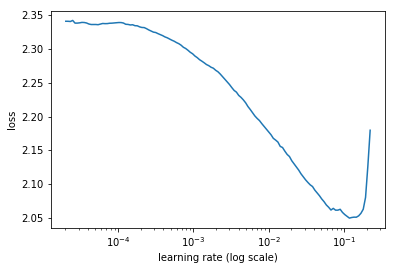

 74%|███████▍  | 146/196 [00:30<00:10,  4.87it/s, loss=19.2]

In [110]:
learner.lr_find()
learner.sched.plot()

The learning rate finder stops early when it reaches its standard cut-off loss.

In [16]:
# train learner at learning rate λr for 2 cycles
%time learner.fit(lr, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.759039   1.636504   0.429395  
    1      1.67167    1.557656   0.449902                   

CPU times: user 1min 24s, sys: 37.8 s, total: 2min 2s
Wall time: 45 s


[1.5576562, 0.44990234375]

In [18]:
# train learner at λr, for 2 cycles, with a cycle length of 1
%time learner.fit(lr, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.614812   1.509444   0.467871  
    1      1.586025   1.489642   0.475488                   

CPU times: user 1min 31s, sys: 39.5 s, total: 2min 11s
Wall time: 53 s


[1.4896423, 0.47548828125]

## 3. ConvNet

In [19]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):    # c: num classes
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i+1], kernel_size=3, stride=2)
            for  i in range(len(layers) - 1)
        ])
        self.pool = nn.AdaptiveMaxPool2d(1)  # define pooling layer to use in forward()
        self.out = nn.Linear(layers[-1], c)  # final FC/Lin layer
        
    def forward(self, x):
        for λ in self.layers: 
            x = F.relu(λ(x))  # same as λ_x=λ(x); x=F.relu(λ_x)
        x = self.pool(x)      # I guess only 1 Conv layer so only 1 Pool at end?
        x = x.view(x.size(0), -1)  # trsfm tensor for final Linlayer
        return F.log_softmax(self.out(x), dim=-1)

In [30]:
learner = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)

In [21]:
learner.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict

Aha, so a v.simple ConvNet. Just one pooling layer after the Conv block. Interesting, the  Adaptive Max Pooling layer transforms our `-1x80x3x3` feature map to a `-1x80x1x1` vector.

Cool, `torch.nn.AdaptiveMaxPool2d(.)` takes one argument for output size. Aha. Wait, is that why it's adaptive? Because it figures out what size it's kernel should be to get the right output?

$\longrightarrow$ Yes. Because `torch.nn.MaxPool2d(..)` takes arguments for kernel size, stride, padding, and etc.

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|████████▎ | 162/196 [00:27<00:05,  5.89it/s, loss=528] 

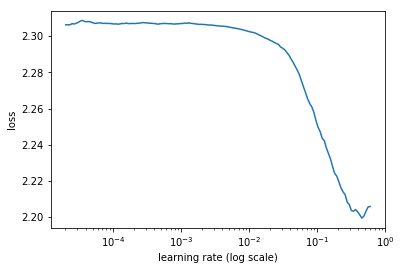

In [28]:
learner.lr_find()
learner.sched.plot()

In [31]:
%time learner.fit(1e-1, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.714783   1.568884   0.428906  
    1      1.515242   1.444738   0.47002                    

CPU times: user 3min 4s, sys: 46.3 s, total: 3min 50s
Wall time: 1min 19s


[1.4447378, 0.47001953125]

In [32]:
%time learner.fit(1e-1, 4, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.342502   1.293992   0.530664  
    1      1.281562   1.226381   0.562793                   
    2      1.266881   1.194723   0.571875                   
    3      1.205737   1.149665   0.589258                   

CPU times: user 6min 6s, sys: 1min 33s, total: 7min 40s
Wall time: 2min 35s


[1.1496648, 0.5892578125]

## 4. Refactored ConvNet

In [34]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x):
        return F.relu(self.conv(x))

`ni`: number in channels
`nf`: number out channels (**number of filters**)

~~Don't know why yet the 'f'. Maybe 'nf' for number features produced? Although the 'channels' are the depth of the conv feat tensor produced.~~

But hell yeah PyTorch. This above allows us to abstract the construction of Conv layers into a neat package we can call the same was we were calling torch.nn.Linear to construct Linear layers before.

In [35]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()  # torch.nn.Module inheritence
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i+1])
                                     for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
    
    def forward(self, x):
        for λ in self.layers:
            x = λ(x)  # yet another way to do x=F.relu(λ(x)) | λ_x=λ(x);x=F.relu(λ_x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=1)

In [44]:
learner = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

In [45]:
learner.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
                 

In [52]:
learner

ConvNet2(
  (layers): ModuleList(
    (0): ConvLayer(
      (conv): Conv2d(3, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): ConvLayer(
      (conv): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (2): ConvLayer(
      (conv): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (out): Linear(in_features=80, out_features=10, bias=True)
)

So it looks like the Adaptive Max Pooling layers are sorta defined along with or folded into the Conv Layers. They were defined more explicitly earlier via: `self.pool = nn.AdaptiveMaxPool2d(out_size)` so the layer shows up as 'AdaptiveMaxPool2d-[num]', but here we have the AdvMPool defined in the forward function via `x=F.adaptive_max_pool2d(x,1)` so it shows up as 'ConvLayer-[num]' instead. Hmm.

Oh interesting, that is the case. Before the AdvPool layer was defined as a `torch.nn.AdaptiveMaxPool2d()` as an attribute during initialization, but now it's defined as a `torch.nn.functional.adaptive_max_pool2d(input, out_size)` as part of the forward pass function. Hmm.

I like the flexibility, but I'm gonna want a way for the layers to at least be named right so I can glance and know what they are.

Aha! From [lecture](https://youtu.be/H3g26EVADgY?t=5063): maxpool in 3. was done as an object, but maxpool doesnt have any state (there're no weights in maxpooling), so it can be done w/ a little less code by calling it as a function in forward.

A lot of (everything?) you can do as a class in PyTorch, you can also do as a function. eg: `torch.nn.AdaptiveMaxPool2d` $\longleftrightarrow$ `torch.nn.functional.adaptive_max_pool2d`

In [46]:
%time learner.fit(1e-1, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.705935   1.698859   0.398145  
    1      1.524254   1.494379   0.451074                   

CPU times: user 3min 25s, sys: 53.4 s, total: 4min 18s
Wall time: 1min 20s


[1.4943792, 0.45107421875]

In [54]:
%time learner.fit(1e-1, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.33932    1.257454   0.545605  
    1      1.256695   1.184349   0.575684                   

CPU times: user 3min 27s, sys: 53.2 s, total: 4min 20s
Wall time: 1min 25s


[1.1843492, 0.57568359375]

## 5. Batch Normalization

Batch Normalization is used to allow creation of deeper networks. You'll find if you try to make the previous networks much deeper, they'll start encountering `NaN` and `0` losses and little in between. BatchNorm increases the resiliency of a neural network.

In [62]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride, 
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf, 1, 1)) # adder
        self.m = nn.Parameter(torch.ones(nf, 1, 1))  # multiplier
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training: # true during training; false during evaluation
            self.means = x_chan.mean(1)[:, None, None] # calc mean of each conv filter (channel)
            self.stds  = x_chan.std(1)[:, None, None]  # calc stdev ofeach conv filter (channel)
        return (x - self.means) / self.stds*self.m + self.a # subtract means, divide by stdevs

[Fast.ai DL1(2018) Lecture 7](https://youtu.be/H3g26EVADgY?t=5692)

**NB**: now we don't need to normalize input at all because its automatically normalizing it per/channel, and for later layers per/filter. But this wont do anything bc SGD will simply undo it all every minibatch.

So we introduce learnable parameters self.a & self.m that SGD can optimize. Now, if SGD wants to scale up or shift the layer, it doesn't need to change the entire layer's weight-matrix, it can just change the numbers of that particular filter $\longrightarrow$ via the channel multiplier or adder.
     
`torch.nn.Parameter` tells SGD it can learn these as weights ie: we flag it for PyTorch to learn it by backprop

**NB2**: BatchNorm also regularizes, meaning you can decrease or remove Dropout and WeightDecay.

The reason is the μ&σ of each minibatch is different $\Longrightarrow$ `self.m` and `self.a` will change w/ea minibatch. This means that the filters are changing slightly w/ea minibatch $\leftrightarrow$ which has the effect of introducing noise $\leftrightarrow$ which is a regularization effect.

**NB3**: for *real* BatchNorm you take an exponentially-weighted moving average of the μ & σ, instead of the current minibatch's μ & σ.

**NB4**: *V.Important*: <<`if self.training:`>> ensures you only use BatchNorm while training. You do **not** want to change the meaning of the model while running on testdata.

...oh my god... you're shitting me...

***THIS*** is why you need to specify multiple versions of the same model in Keras, because it's a Static-Computation framework. That was very confusing for me in v1 of the GLoC Detector adapting Keras-RetinaNet's training API via L.Fridman's Boring Detector...

Oy.

In [63]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
                                     for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for λ in self.layers:
            x = λ(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

Here a large conv layer is added to the start, with a large kernel size and stride 1. The **idea** is to have an input layer with a richer input. We use bigger filters on bigger areas; and output 10 5x5 filters. Current (2018) modern approach. (sometimes even 11x11 kernel & 32 out filters). $Stride = 1$ along with $padding = \dfrac{kernelsize - 1}{2}$ ie: `padding=2` here, allows us to have an output with the same size as our input, but with more filters.

In [64]:
# 5 Conv layerse + 1 FC layer
learner = ConvLearner.from_model_data(ConvBnNet([10,20,40,80,160], 10), data)

In [65]:
learner.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BnLayer-5',
              OrderedDict([

In [66]:
%time learner.fit(3e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.491893   1.32506    0.52207   
    1      1.235412   1.15048    0.593848                   

CPU times: user 9min 43s, sys: 1min 58s, total: 11min 41s
Wall time: 4min 24s


[1.1504797, 0.59384765625]

In [67]:
%time learner.fit(1e-1, 4, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.125073   1.018354   0.637305  
    1      1.005073   0.932572   0.670312                   
    2      0.948752   0.910524   0.677344                    
    3      0.908414   0.830293   0.707715                    

CPU times: user 19min 13s, sys: 4min 5s, total: 23min 18s
Wall time: 9min 50s


[0.8302928, 0.70771484375]

## 6. Deep BatchNorm

We can't just add more stride=2 Conv layers because we're already down to $2\times2$ by our 5th conv layer (the 80 filters $\rightarrow$ in, 160 fltrs $\rightarrow$ out layer).

Instead what we do is create stride=1 layers, and build our network as pairs of $[CONV(stride=2),CONV(stride=1)]$, effectively doubling the depth of our model. ($\forall$ the looped-layers, that is)

In [73]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
                                     for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i+1], 1)
                                      for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for λ, λ2 in zip(self.layers, self.layers2):
            x = λ(x)
            x = λ2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [74]:
# creates a 12-layer ConvNet. 1 larger Conv in, 10 conv middle, 1 Lin out.
learner = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [75]:
%time learner.fit(1e-2,2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.516019   1.355391   0.507617  
    1      1.292743   1.183779   0.569727                   

CPU times: user 15min 44s, sys: 2min 55s, total: 18min 39s
Wall time: 7min 54s


[1.1837785, 0.5697265625]

Accuracy notes:

* Simple Neural Net: `47%`

* ConvNet: `58%`

* Refactored ConvNet: `57%`

* ConvNet w/ BatchNorm: `70%`

* Deep ConvNet w/ BatchNorm: `57%`

... wait why didn't a deeper batchnorm'd network do even better? Well, at 12 layers in, we're so deep even BatchNorm can't help us. And this is where we introduce: **Residual Networks**.

## 7. ResNet

What `ResNetLayer` will do is inherit from `BnLayer` and replace/redefine the `forward` function:

In [80]:
class ResnetLayer(BnLayer):
    def forward(self, x):
        return x + super().forward(x)
# forward fn of ResNetLayer is to return the input along with 
# the output of the inherited forward fn from BnLayer, applied to 
# the input.

That's *it*. Everything else will be identical.. except we can now do ***way*** more layers than before.

We're going to make it 3x as deep as before and it's going to train great, just because of that one line: `x + super().forward(x)`

In [81]:
class ResNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
                                     for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1)
                                      for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1)
                                      for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for λ, λ2, λ3 in zip(self.layers, self.layers2, self.layers3):
            x = λ3(λ3(λ(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [82]:
learner = ConvLearner.from_model_data(ResNet([10,20,40,80,160],10), data)

In [83]:
# weight decay
wd = 1e-5

In [84]:
%time learner.fit(1e-2, 2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.651477   1.520138   0.442969  
    1      1.373729   1.361656   0.510742                   

CPU times: user 21min 56s, sys: 4min 15s, total: 26min 11s
Wall time: 13min 15s


[1.361656, 0.5107421875]

The big difference between this and actual residual networks is that there are often 2 convolutions in residual instead of 1 here. That's the `.. + super().forward(x)`

Also note that the first layer-block: `self.layers` isn't a ResNet block, but instead a standard stride=2 BatchNorm'd convolutional block. This is called a **bottleneck layer**, the idea is to change the network's geometry from time to time (using the stride=2 or other).

Actual ResNets don't use standard Convolutions as Bottleneck Blocks (partII).

---

Now, on a Core i5 MacBook Pro with no parallel processor, this is gonna take some time. So take my word for it here or I'll/train it later w/ a GPU.

In [ ]:
%time learner.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
%time learner.fit(1e-2, 8, cycle_len=4, wds=wd)

## 8. ResNet (bigger)

This basically just adds Dropout, and also changes the input Conv layer to produce 16 filters instead of 10, with a kernel size of 7 instead of 5.

In [85]:
class ResNet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
                                     for i in range(len(layers) - 1)])
        self.layers2= nn.ModuleList([ResnetLayer(layers[i+1],layers[i+1], 1)
                                     for i in range(len(layers) - 1)])
        self.layers3= nn.ModuleList([ResnetLayer(layers[i+1],layers[i+1], 1)
                                     for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop= nn.Dropout(p)

    def forward(self, x):
        x = self.conv1(x)
        for λ, λ2, λ3 in zip(self.layers, self.layers2, self.layers3):
            x = λ3(λ2(λ(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [86]:
learner = ConvLearner.from_model_data(ResNet2([16,32,128,256], 10, 0.2), data)

In [88]:
wd=1e-6

In [89]:
%time learner.fit(1e-2, 2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.121443   2.33394    0.389941  
    1      1.867317   1.760342   0.43623                    

CPU times: user 44min 46s, sys: 7min 8s, total: 51min 54s
Wall time: 27min 42s


[1.7603419, 0.43623046875]

In [ ]:
%time learner.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
%time learner.fit(1e-2, 8, cycle_len=4, wds=wd)

In [ ]:
learner.save('tmp')

In [ ]:
log_preds, y = learner.TTA()
preds = np.mean(np.exp(log_preds), 0)

In [ ]:
metrics.log_loss(y, preds), accuracy(preds, y)